# In this notebook, we will examine simple statistical methods of prediction and anomaly detection and see if there is any substantial difference

This is for 32 thread throughput

In [5]:
#https://keras.io/examples/timeseries/timeseries_transformer_classification/
logger_name = "lstnet"

# Path appended in order to import from util
import sys
sys.path.append('..')
# from util.model_util import LoadModel, SaveModel, SaveResults, SaveHistory
# from util.Msglog import LogInit

from datetime import datetime

#from lstnet_util import GetArguments, LSTNetInit
from pandas_data_util import DataUtil
#from lstnet_model import PreSkipTrans, PostSkipTrans, PreARTrans, PostARTrans, LSTNetModel, ModelCompile
#from lstnet_plot import AutoCorrelationPlot, PlotHistory, PlotPrediction

import tensorflow as tf
import argparse

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
# from tensorflow.keras import backend as K


In [6]:
tf.__version__

'2.9.1'

In [7]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Import data and process it using DataUtil
look at pandas_util for more info about this

In [ ]:
# Reading data
filename = 'data/bq_results_09082022.csv'
trainpercent = 0.6
validpercent = 0.2
horizon=0
window=10
normalize=0

# query='vm_1_gce_network_tier == "premium"'
query = 'vm_1_gce_network_tier == "premium" and vm_1_machine_type == "n1-standard-16" and ip_type == "internal" and tcp_congestion_control == "bbr"'

Data = DataUtil(filename,
                trainpercent,
                validpercent,
                horizon,
                window,
                normalize=normalize,
                query=query)


In [ ]:
print(Data.train[0].shape)
# print(Data.train[0])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10,
                                                mode='min')

In [ ]:
data_col_top = 4

In [ ]:
adjusted_data_columns = Data.columns[1:data_col_top]

In [ ]:
adjusted_data_columns

In [ ]:
num_vars = len(adjusted_data_columns)

In [ ]:
data_train_x_float32 = np.array(list(Data.train[0][:,:,1:data_col_top])).astype(np.float32)
data_train_y_float32 = np.array(list(Data.train[1][:,1:data_col_top])).astype(np.float32)
data_train_y_float32_32_thread_reshaped = data_train_y_float32[:,1].reshape(data_train_y_float32[:,1].shape[0],1)
data_train_y_float32_1_thread_reshaped = data_train_y_float32[:,0].reshape(data_train_y_float32[:,0].shape[0],1)

data_valid_x_float32 = np.array(list(Data.valid[0][:,:,1:data_col_top])).astype(np.float32)
data_valid_y_float32 = np.array(list(Data.valid[1][:,1:data_col_top])).astype(np.float32)
data_valid_y_float32_32_thread_reshaped = data_valid_y_float32[:,1].reshape(data_valid_y_float32[:,1].shape[0],1)
data_valid_y_float32_1_thread_reshaped = data_valid_y_float32[:,0].reshape(data_valid_y_float32[:,0].shape[0],1)

data_test_x_float32 = np.array(list(Data.test[0][:,:,1:data_col_top])).astype(np.float32)
data_test_y_float32 = np.array(list(Data.test[1][:,1:data_col_top])).astype(np.float32)
data_test_y_float32_32_thread_reshaped = data_test_y_float32[:,1].reshape(data_test_y_float32[:,1].shape[0],1)
data_test_y_float32_1_thread_reshaped = data_test_y_float32[:,0].reshape(data_test_y_float32[:,0].shape[0],1)

In [ ]:
accuracy_stats = {}
accuracy_stats['rmse'] = {}
accuracy_stats['rse'] = {}
accuracy_stats['corr'] = {}
accuracy_stats['accuracy'] = {}
accuracy_stats['mae'] = {}
accuracy_stats['predicted'] = {}
accuracy_stats['mse'] = {}

In [ ]:
import scipy
import matplotlib.cm as cm

def SimpleAnomalyDetection(actual, predicted, data_high, data_low=0, threshold=3):
  # Finds average difference for entire data range
  # if point is more different than this, it is an anomaly
  # return anomaly list

  anomaly_index_list = []
  count = 0
  total=0
  for x in range(data_low, data_high):
      difference = abs(actual[x]-predicted[x])
      total = difference + total
      count += 1
  average = total / count
  print(f"The Average is: {average}")
  count = 0
  for x in range(data_low, data_high):
      difference = abs(actual[x]-predicted[x])
      if difference > threshold*average:
          # anomaly_list.append(data_test_y_float32_32_thread_reshaped[x])
          # anomaly_list_x_coords.append(count)
          anomaly_index_list.append(x)
      count += 1
  print(anomaly_index_list)
  return anomaly_index_list

# Define some error metrics we can use that aren't in tf

In [ ]:
#Root relative squared error
def tf_rse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square(y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = K.sqrt(K.mean(K.square(y_true - y_pred), axis=None))
    den = K.std(y_true, axis=None)
    
    return num / den

def rse_test1(y_true, y_pred):
    return K.square(y_true - y_pred)

def rse_test2(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred), axis=None))

def rse_test3(y_true, y_pred):
    return K.std(y_true, axis=None)

def rse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square( y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = np.sqrt(np.mean(np.square(y_true - y_pred), axis=None))
    den = np.std(y_true, axis=None)
    
    return num / den

def tf_corr(y_true, y_pred):
    #
    # This function calculates the correlation between the true and the predicted outputs
    #
    num1 = y_true - K.mean(y_true, axis=0)
    num2 = y_pred - K.mean(y_pred, axis=0)
    
    num  = K.mean(num1 * num2, axis=0)
    den  = K.std(y_true, axis=0) * K.std(y_pred, axis=0)
    
    return K.mean(num / den)

def corr(y_true, y_pred):
    #
    # This function calculates the correlation between the true and the predicted outputs
    #
    num1 = y_true - np.mean(y_true, axis=0)
    num2 = y_pred - np.mean(y_pred, axis=0)
    
    num  = np.mean(num1 * num2, axis=0)
    den  = np.std(y_true, axis=0) * np.std(y_pred, axis=0)
    
    return np.mean(num / den)

def single_rse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square(y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = K.sqrt(K.mean(K.square(y_true[:,0] - y_pred[:,0]), axis=None))
    den = K.std(y_true, axis=None)
    
    return num / den


def single_corr(y_true, y_pred):
    #
    # This function calculates the correlation between the true and the predicted outputs
    #
    num1 = y_true[:,0] - K.mean(y_true[:,0], axis=0)
    num2 = y_pred[:,0] - K.mean(y_pred[:,0], axis=0)
    
    num  = K.mean(num1 * num2, axis=0)
    den  = K.std(y_true[:,0], axis=0) * K.std(y_pred[:,0], axis=0)
    
    return K.mean(num / den)

# First let us just look at a moving average predictor

In [ ]:
data_test_x_float32.shape

In [ ]:
type(data_test_x_float32)

In [ ]:
data_test_x_float32[:,:,1].shape

In [ ]:
a = data_test_x_float32[:,:,1]

In [ ]:
a[0].shape[0]

In [ ]:
np.mean(a[0])

In [ ]:
def moving_average_predictor(data_set: np.ndarray) -> np.ndarray:
  nrows = data_set.shape[0]
  ncols = data_set.shape[1]
  predicted_array = np.empty(nrows, dtype=np.float32)
    
  for i in range(0, nrows):
    predicted_array[i] = np.mean(data_set[i,:])
  
  
  return predicted_array
  
  

In [ ]:
moving_average_predicted = moving_average_predictor(data_test_x_float32[:,:,1])

moving_average_predicted.shape

In [ ]:
moving_average_predicted

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

mse = mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), moving_average_predicted)
rmse = sqrt(mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), moving_average_predicted))
mae = mean_absolute_error(data_test_y_float32_32_thread_reshaped.flatten(), moving_average_predicted)
rse_val = rse(data_test_y_float32_32_thread_reshaped.flatten(), moving_average_predicted)
mape = mean_absolute_percentage_error(data_test_y_float32_32_thread_reshaped.flatten(), moving_average_predicted)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')
print(f'MAPE: {mape}')

# accuracy_stats['rmse']['cnn'] = rmse
# accuracy_stats['rse']['cnn'] = rse_val
# # accuracy_stats['corr']['mlp'] = corr
# # accuracy_stats['accuracy']['mlp'] = acc
# accuracy_stats['mae']['cnn'] = mae
# accuracy_stats['predicted']['cnn'] = cnn_predicted
# accuracy_stats['mse']['cnn'] = mse

In [ ]:
plt.figure(figsize=(25, 8))
data_high = 2000
data_low = 0
anomaly_index_list = SimpleAnomalyDetection(data_test_y_float32_32_thread_reshaped, moving_average_predicted, data_high, data_low=data_low, threshold=2)

anomaly_y_coords = []

for x in anomaly_index_list:
  anomaly_y_coords.append(data_test_y_float32_32_thread_reshaped[x])

print(f"The len of anomalyList: {len(anomaly_index_list)}")
colors = cm.rainbow(np.linspace(1, 1, len(anomaly_index_list)))
plt.plot(data_test_y_float32_32_thread_reshaped[data_low:data_high])
plt.plot(moving_average_predicted[data_low:data_high])
plt.scatter(anomaly_index_list, anomaly_y_coords, c=colors)

plt.legend(["Actual", "Anomoly Points"])
plt.show()

In [ ]:
moving_avg_predicted_scaled = moving_average_predicted * Data.iperf_32_thread_std + Data.iperf_32_thread_mean

In [ ]:
plt.plot(moving_avg_predicted_scaled[data_low:data_high])

In [ ]:
Data.test[1].shape

In [ ]:
moving_average_predicted[0]

In [ ]:
data_test_y_float32_32_thread_reshaped[0]

In [ ]:
Data.test[1][0,2]

In [ ]:
mean = Data.test[1][0,14]
std = Data.test[1][0,15]

In [ ]:
mean - std*2

To define an anomaly for evaluation, we are combining two approaches. First we take the test dataset and statistically define anomalies.
For each time series, we find the mean and standard deviation of that series. We then label anything outside of mean +- 2*std as an anomaly.
We then manually went through the dataset and marked values that we thought were sufficiently different from their neighbors to be considered anomalous.

To detect anomalies from our prediction models, we take the difference between the prediction and the actual measured value and compare that to our average prediction error. If the prediction error is above mean prediction error plus some threshold, we label this as a detected anomaly.

This should allow us to compare the anomaly detection performance of different prediction models. 

In [ ]:
true_positives = []
false_positives = []
false_negatives = []
true_negatives = []
actual_anomalies = []

total = 0
count = 0

group_average = []


for i in range(0,2000):
  predicted_value = moving_average_predicted[i] * Data.iperf_32_thread_std + Data.iperf_32_thread_mean
  actual_value = Data.test[1][i,2] * Data.iperf_32_thread_std + Data.iperf_32_thread_mean
  difference = abs(actual_value-predicted_value)
  total = difference + total
  count += 1
average = total / count

for i in range(0,2000):
  predicted_value = moving_average_predicted[i] * Data.iperf_32_thread_std + Data.iperf_32_thread_mean
  actual_value = Data.test[1][i,2] * Data.iperf_32_thread_std + Data.iperf_32_thread_mean
  mean = Data.test[1][i,14]
  std = Data.test[1][i,15]
  
  anomaly = False
  if actual_value > mean + 2*std or actual_value < mean - 2*std:
    anomaly = True
  
  anomaly_detected = False
  difference = abs(actual_value-predicted_value)
  if difference > 1.4*average:
    anomaly_detected = True
  
  if anomaly:
    actual_anomalies.append(i)
    if anomaly_detected:
      true_positives.append(i)
    else:
      
      false_negatives.append(i)
  else:
    if anomaly_detected:
      # print(f'threshold: {anomaly_threshold}, predicted: {predicted_value}, actual: {actual_value}, diff: {difference}, ')
      false_positives.append(i)
    else:
      true_negatives.append(i)

true_positives_y_coords = []      
for x in true_positives:
  true_positives_y_coords.append(data_test_y_float32_32_thread_reshaped[x] * Data.iperf_32_thread_std + Data.iperf_32_thread_mean)

false_positives_y_coords = []
for x in false_positives:
  false_positives_y_coords.append(data_test_y_float32_32_thread_reshaped[x] * Data.iperf_32_thread_std + Data.iperf_32_thread_mean)

false_negatives_y_coords = []
for x in false_negatives:
  false_negatives_y_coords.append(data_test_y_float32_32_thread_reshaped[x] * Data.iperf_32_thread_std + Data.iperf_32_thread_mean)
  
print(f'TP {len(true_positives)}')
print(f'FP {len(false_positives)}')
print(f'FN {len(false_negatives)}')
print(f'TN {len(true_negatives)}')
print(f'Anomalies: {len(actual_anomalies)}')

In [ ]:
plt.figure(figsize=(25, 8))
plt.plot(data_test_y_float32_32_thread_reshaped[data_low:data_high]* Data.iperf_32_thread_std + Data.iperf_32_thread_mean)
plt.plot(moving_average_predicted[data_low:data_high]* Data.iperf_32_thread_std + Data.iperf_32_thread_mean)
plt.scatter(true_positives, true_positives_y_coords, c='g')
plt.scatter(false_positives, false_positives_y_coords, c='r')
plt.scatter(false_negatives, false_negatives_y_coords, c='pink')

plt.legend(["Actual", "Anomoly Points"])
plt.show()

In [ ]:
false_negatives

In [134]:
false_positives

[14,
 39,
 50,
 53,
 54,
 71,
 92,
 148,
 153,
 156,
 173,
 177,
 181,
 199,
 205,
 213,
 221,
 239,
 252,
 256,
 269,
 279,
 281,
 301,
 379,
 392,
 405,
 406,
 455,
 459,
 471,
 472,
 473,
 475,
 476,
 485,
 492,
 494,
 505,
 507,
 508,
 510,
 520,
 524,
 538,
 553,
 564,
 566,
 595,
 602,
 611,
 616,
 622,
 632,
 636,
 637,
 645,
 651,
 666,
 695,
 697,
 700,
 723,
 728,
 754,
 755,
 768,
 769,
 786,
 788,
 798,
 802,
 813,
 830,
 837,
 852,
 857,
 862,
 889,
 893,
 900,
 901,
 906,
 912,
 917,
 920,
 927,
 937,
 956,
 964,
 966,
 970,
 976,
 980,
 981,
 986,
 990,
 993,
 997,
 998,
 999,
 1000,
 1016,
 1024,
 1025,
 1028,
 1035,
 1040,
 1041,
 1046,
 1048,
 1052,
 1053,
 1057,
 1062,
 1065,
 1077,
 1078,
 1080,
 1082,
 1085,
 1100,
 1101,
 1114,
 1122,
 1129,
 1132,
 1135,
 1140,
 1144,
 1149,
 1150,
 1160,
 1170,
 1173,
 1174,
 1175,
 1179,
 1182,
 1198,
 1202,
 1203,
 1204,
 1207,
 1215,
 1216,
 1223,
 1225,
 1229,
 1247,
 1264,
 1271,
 1272,
 1273,
 1275,
 1276,
 1277,
 1278,
 1

In [135]:
i = 39

predicted_value = moving_average_predicted[i] * Data.iperf_32_thread_std + Data.iperf_32_thread_mean
actual_value = Data.test[1][i,2] * Data.iperf_32_thread_std + Data.iperf_32_thread_mean
mean = Data.test[1][i,14]
std = Data.test[1][i,15]

anomaly_detected = False
difference = abs(actual_value-predicted_value)
if difference > 1.5*average:
  anomaly_detected = True

print(f'predicted: {predicted_value}')
print(f'actual: {actual_value}')
print(f'group mean: {mean}')
print(f'group std: {std}')
print(f'anomaly threshold: {mean - (2*std)}, {mean + (2*std)}')

print(f'diff:{difference}')
print(f'diff thres: {1.5*average}')


if actual_value > mean + 2*std or actual_value < mean - 2*std:
  print("anomaly = true")
else:
  print("anomaly = false")

predicted: 23824.80004289665
actual: 28884.0
group mean: 25110.85
group std: 2387.6366326491866
anomaly threshold: 20335.576734701626, 29886.12326529837
diff:5059.199957103348
diff thres: 3410.145909140104
anomaly = false


In [126]:
predicted_value

27394.40038603074

70

In [97]:
len(false_positives)

78

In [98]:
len(true_negatives)

1797

In [99]:
len(false_negatives)

55

## Weighted moving average predictor

In [29]:
def weighted_moving_average_predictor(data_set: np.ndarray, weights: np.ndarray) -> np.ndarray:
  nrows = data_set.shape[0]
  ncols = data_set.shape[1]
  
  if weights.shape[0] != ncols:
    raise ValueError(f"length of weights {weights.shape[0]} should equal number of cols {ncols}")
  
  predicted_array = np.empty(nrows, dtype=np.float32)
    
  for i in range(0, nrows):
    predicted_array[i] = np.ma.average(data_set[i,:], weights=weights)
  
  
  return predicted_array

In [30]:
weights = np.array([1,2,3,4,5,6,7,8,9,10])

weights

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [31]:
weighted_moving_average_predicted = weighted_moving_average_predictor(data_test_x_float32[:,:,1], weights)

weighted_moving_average_predicted

array([0.9749075, 0.9904354, 1.0114268, ..., 1.1118795, 1.1045998,
       1.0642475], dtype=float32)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

mse = mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), weighted_moving_average_predicted)
rmse = sqrt(mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), weighted_moving_average_predicted))
mae = mean_absolute_error(data_test_y_float32_32_thread_reshaped.flatten(), weighted_moving_average_predicted)
rse_val = rse(data_test_y_float32_32_thread_reshaped.flatten(), weighted_moving_average_predicted)
mape = mean_absolute_percentage_error(data_test_y_float32_32_thread_reshaped.flatten(), weighted_moving_average_predicted)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')
print(f'MAPE: {mape}')

# accuracy_stats['rmse']['cnn'] = rmse
# accuracy_stats['rse']['cnn'] = rse_val
# # accuracy_stats['corr']['mlp'] = corr
# # accuracy_stats['accuracy']['mlp'] = acc
# accuracy_stats['mae']['cnn'] = mae
# accuracy_stats['predicted']['cnn'] = cnn_predicted
# accuracy_stats['mse']['cnn'] = mse

MSE: 0.09801055490970612
RMSE: 0.31306637460721665
MAE: 0.21653705835342407
RSE: 0.9145030379295349
MAPE: 2.117671489715576


The Average is: [0.23513725]
[28, 43, 47, 50, 61, 65, 76, 85, 101, 146, 173, 174, 226, 285, 287, 291, 295, 322, 323, 324, 325, 330, 458, 461, 463, 470, 501, 519, 521, 523, 528, 542, 543, 544, 545, 570, 579, 580, 584, 594, 600, 601, 622, 623, 629, 645, 712, 716, 742, 745, 753, 755, 762, 773, 777, 796, 797, 805, 811, 812, 873, 876, 908, 986, 989, 1010, 1018, 1027, 1031, 1032, 1042, 1065, 1110, 1112, 1124, 1128, 1178, 1182, 1196, 1198, 1200, 1213, 1214, 1218, 1221, 1227, 1234, 1238, 1245, 1260, 1283, 1287, 1294, 1306, 1308, 1318, 1343, 1378, 1379, 1382, 1457, 1459, 1460, 1461, 1462, 1463, 1469, 1509, 1511, 1528, 1534, 1593, 1603, 1690, 1691, 1692, 1697, 1698, 1703, 1704, 1705, 1707, 1708, 1709, 1711, 1712, 1715, 1720, 1722, 1723, 1725, 1727, 1728, 1730, 1731, 1732, 1733, 1734, 1735, 1738, 1741, 1752, 1759, 1762, 1763, 1764, 1765, 1766, 1768, 1770, 1774, 1775, 1776, 1779, 1781, 1787, 1790, 1794, 1798, 1799, 1801, 1802, 1803, 1807, 1808, 1810, 1813, 1814, 1815, 1817, 1820, 1822, 1824, 1827,

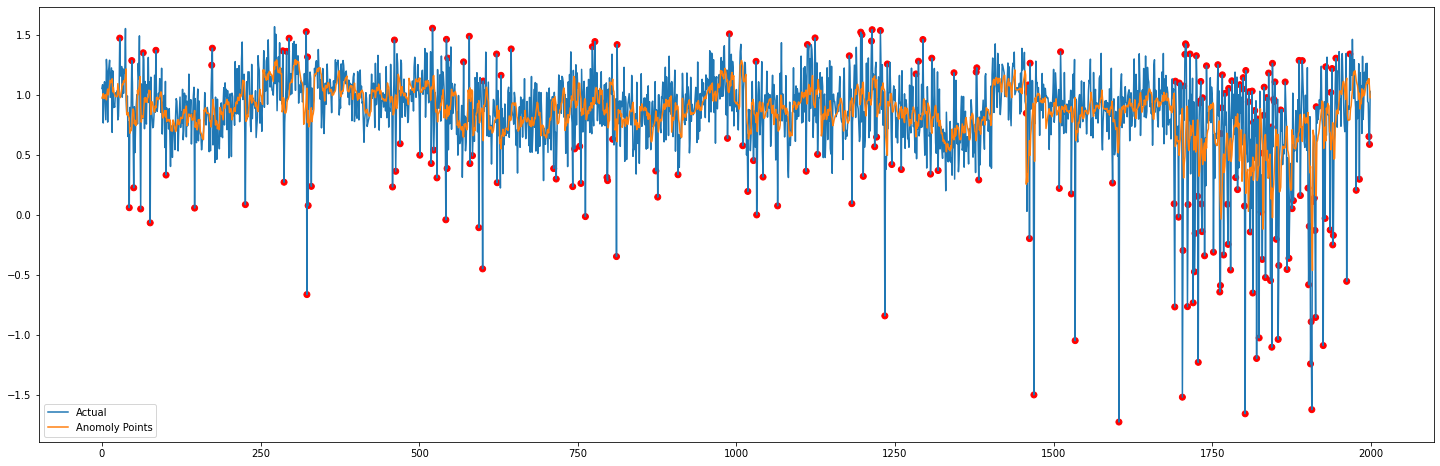

In [33]:
plt.figure(figsize=(25, 8))
data_high = 2000
data_low = 0
anomaly_index_list = SimpleAnomalyDetection(data_test_y_float32_32_thread_reshaped, weighted_moving_average_predicted, data_high, data_low=data_low, threshold=2)

anomaly_y_coords = []

for x in anomaly_index_list:
  anomaly_y_coords.append(data_test_y_float32_32_thread_reshaped[x])

print(f"The len of anomalyList: {len(anomaly_index_list)}")
colors = cm.rainbow(np.linspace(1, 1, len(anomaly_index_list)))
plt.plot(data_test_y_float32_32_thread_reshaped[data_low:data_high])
plt.plot(weighted_moving_average_predicted[data_low:data_high])
plt.scatter(anomaly_index_list, anomaly_y_coords, c=colors)

plt.legend(["Actual", "Anomoly Points"])
plt.show()

## Exponential moving average

In [34]:
def exponential_moving_average_predictor(data_set: np.ndarray, k: float) -> np.ndarray:
  nrows = data_set.shape[0]
  ncols = data_set.shape[1]
  
  if weights.shape[0] != ncols:
    raise ValueError(f"length of weights {weights.shape[0]} should equal number of cols {ncols}")
  
  predicted_array = np.empty(nrows, dtype=np.float32)
    
  for i in range(0, nrows):
    predicted_array[i] = np.ma.average(data_set[i,:], weights=weights)
  
  
  return predicted_array

In [35]:
# exponential_moving_average_predicted = weighted_moving_average_predictor(data_test_x_float32[:,:,1], weights)

# exponential_moving_average_predicted

In [36]:

ema = d[0]
ema = (d[1]*(smooth/(1+days))) + ema*(1-(smoothing/(1+days)))

NameError: name 'd' is not defined

# Exponential Smoothing

In [37]:
y = [3, 5, 9, 20]

## Start with the first point
forcast = [y[0]]
alpha = .4

for i in range(1, len(y)):
    predict = alpha * y[i - 1] + (1 - alpha) * forcast[i - 1]
    forcast.append(predict)

forcast

[3, 3.0, 3.8, 5.88]

In [38]:
data_set = data_test_x_float32[:,:,1]
i = 2
ncols = 10
alpha = 0.2
forecast = data_set[i,0]
for x in range(1, ncols+1):
  print(x)
  predict = alpha * data_set[i,x-1] + (1 - alpha) * forecast
  forecast = predict

1
2
3
4
5
6
7
8
9
10


In [39]:
forecast

1.0318653113200074

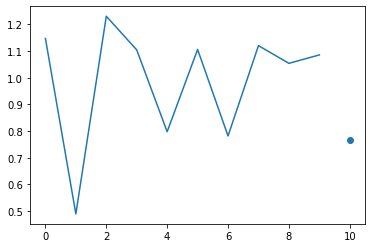

In [40]:
plt.plot(data_set[i,:])
plt.scatter([10], data_test_y_float32_32_thread_reshaped[i])
plt.plot(forecast)

In [41]:
def exponential_smoothing_predictor(data_set: np.ndarray, alpha: float) -> np.ndarray:
  nrows = data_set.shape[0]
  ncols = data_set.shape[1]
  predicted_array = np.empty(nrows, dtype=np.float32)
    
  for i in range(0, nrows):
    predict = data_set[i,0]
    for x in range(1, ncols+1):
      predict = alpha * data_set[i,x-1] + (1 - alpha) * predict
    predicted_array[i] = predict
  
  
  return predicted_array

In [42]:
exponential_smoothing_predicted = exponential_smoothing_predictor(data_test_x_float32[:,:,1], alpha=0.3)

exponential_smoothing_predicted

array([0.98899126, 1.0036556 , 1.0360256 , ..., 1.1374681 , 1.1296998 ,
       1.0506862 ], dtype=float32)

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

mse = mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), exponential_smoothing_predicted)
rmse = sqrt(mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), exponential_smoothing_predicted))
mae = mean_absolute_error(data_test_y_float32_32_thread_reshaped.flatten(), exponential_smoothing_predicted)
rse_val = rse(data_test_y_float32_32_thread_reshaped.flatten(), exponential_smoothing_predicted)
mape = mean_absolute_percentage_error(data_test_y_float32_32_thread_reshaped.flatten(), exponential_smoothing_predicted)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')
print(f'MAPE: {mape}')

# accuracy_stats['rmse']['cnn'] = rmse
# accuracy_stats['rse']['cnn'] = rse_val
# # accuracy_stats['corr']['mlp'] = corr
# # accuracy_stats['accuracy']['mlp'] = acc
# accuracy_stats['mae']['cnn'] = mae
# accuracy_stats['predicted']['cnn'] = cnn_predicted
# accuracy_stats['mse']['cnn'] = mse

MSE: 0.10099171102046967
RMSE: 0.3177919303891615
MAE: 0.22068822383880615
RSE: 0.9283069968223572
MAPE: 2.160425901412964


The Average is: [0.24067244]
[28, 43, 47, 50, 61, 65, 76, 101, 146, 175, 226, 246, 287, 322, 323, 324, 325, 330, 458, 461, 463, 501, 519, 521, 523, 528, 529, 542, 543, 544, 545, 570, 579, 580, 584, 594, 600, 601, 622, 623, 629, 645, 712, 716, 742, 745, 753, 755, 756, 762, 773, 796, 797, 805, 811, 812, 873, 876, 908, 1010, 1018, 1031, 1032, 1042, 1065, 1110, 1112, 1124, 1128, 1150, 1178, 1182, 1196, 1200, 1213, 1218, 1227, 1234, 1238, 1245, 1260, 1287, 1294, 1308, 1317, 1318, 1343, 1344, 1378, 1382, 1457, 1459, 1460, 1462, 1463, 1469, 1470, 1509, 1511, 1528, 1534, 1535, 1593, 1602, 1603, 1690, 1691, 1692, 1697, 1698, 1703, 1704, 1705, 1707, 1708, 1711, 1713, 1715, 1716, 1720, 1721, 1722, 1723, 1725, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1738, 1741, 1752, 1759, 1762, 1763, 1764, 1765, 1766, 1768, 1770, 1774, 1775, 1776, 1779, 1781, 1787, 1790, 1794, 1798, 1799, 1801, 1802, 1803, 1807, 1808, 1810, 1813, 1814, 1815, 1820, 1822, 1824, 1827, 1829, 1830, 1831, 1832, 1834, 1836

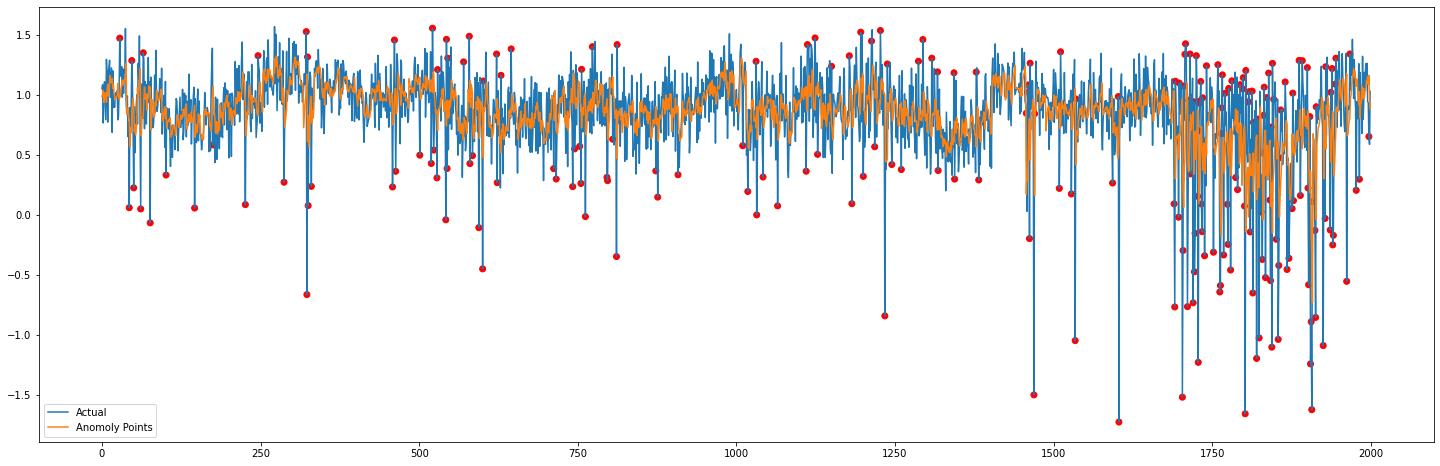

In [44]:
plt.figure(figsize=(25, 8))
data_high = 2000
data_low = 0
anomaly_index_list = SimpleAnomalyDetection(data_test_y_float32_32_thread_reshaped, exponential_smoothing_predicted, data_high, data_low=data_low, threshold=2)

anomaly_y_coords = []

for x in anomaly_index_list:
  anomaly_y_coords.append(data_test_y_float32_32_thread_reshaped[x])

print(f"The len of anomalyList: {len(anomaly_index_list)}")
colors = cm.rainbow(np.linspace(1, 1, len(anomaly_index_list)))
plt.plot(data_test_y_float32_32_thread_reshaped[data_low:data_high])
plt.plot(exponential_smoothing_predicted[data_low:data_high])
plt.scatter(anomaly_index_list, anomaly_y_coords, c=colors)

plt.legend(["Actual", "Anomoly Points"])
plt.show()